In [1]:
!pip install deepface ultralytics faiss-cpu pandas

In [48]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

import numpy as np
import faiss

In [49]:
model_name = "Facenet" 
detector_backend = "opencv"
num_dimensions = 128 # Facenet output

In [50]:
representations = []

# Inisialisasi DataFrame Pandas untuk menyimpan nama orang dan embedding
df = pd.DataFrame(columns=["name", "embedding", "posisi"])

# Dictionary untuk mapping file_name ke nama orang
file_to_name = {
    "img5.jpg" : "Angelina Jolie",
    "img6.jpg" : "Angelina Jolie",
    "img14.jpg" : "Mark Zuckerberg",
    "img15.jpg" : "Mark Zuckerberg",
    "img17.jpg" : "Jack Dorsey",
    "img54.jpg" : "Jennifer Aniston",
    "img56.jpg" : "Jennifer Aniston",
    "img62.jpg" : "Jack Dorsey",
    "heydar.jpg" : "Heydar",
    "ica.jpg" : "Ica",
    "nola.jpg" : "Nola",
    "indah.jpg" : "Indah",
    "irsan.jpg" : "Irsan",
    "zeyad.jpg" : "Zeyad"
}
name_to_position = {
    "Angelina Jolie" : "Oscar Actress",
    "Mark Zuckerberg" : "CEO Meta",
    "Jack Dorsey" : "CEO Square",
    "Jennifer Aniston" : "Friends serial actress",
    "Heydar" : "walkot",
    "Ica" : "Engineer",
    "Nola" : "CEO rokan hulu",
    "Indah" : "Dirut elnusa",
    "Irsan" : "bupati sleman",
    "Zeyad" : "raja arab"
}
for r, d, files in os.walk("../Belajar-DeepFace"):
    for file in files:
        if ".jpg" in file:
            exact_file = f"{r}/{file}"
            objs = DeepFace.represent(
                img_path=exact_file,
                model_name=model_name,
                detector_backend=detector_backend
            )
            
            # Dapatkan nama orang dari dictionary
            name = file_to_name.get(file, "Unknown")  # Jika file tidak ada dalam dictionary, beri nama 'Unknown'
            posisi = name_to_position.get(name, "unknown position")
            for obj in objs:
                embedding = obj["embedding"]
                representations.append([file, embedding])
                
                # Buat DataFrame baru dari nama dan embedding yang dihasilkan
                new_row = pd.DataFrame({"name": [name], "embedding": [embedding], "posisi": [posisi]})
                
                # Gabungkan DataFrame baru ke DataFrame utama menggunakan pd.concat()
                df = pd.concat([df, new_row], ignore_index=True)

In [51]:
print(df)

                name                                          embedding  \
0             Heydar  [0.970146656036377, -0.8604631423950195, -1.06...   
1                Ica  [-0.12632405757904053, 0.4273875057697296, 0.1...   
2    Mark Zuckerberg  [-1.1351804733276367, -0.8694196939468384, -1....   
3    Mark Zuckerberg  [-1.1018025875091553, -0.8272180557250977, -1....   
4        Jack Dorsey  [-0.9749081134796143, -0.7117679119110107, -1....   
5     Angelina Jolie  [-0.9477615356445312, 0.3950583338737488, 1.10...   
6   Jennifer Aniston  [-1.1367212533950806, 0.8382776975631714, -0.7...   
7   Jennifer Aniston  [-0.2428610920906067, 1.451387643814087, -0.28...   
8     Angelina Jolie  [-0.12287281453609467, 1.0534143447875977, 1.5...   
9        Jack Dorsey  [-0.9425899982452393, -1.3567513227462769, -0....   
10             Indah  [1.0456628799438477, 0.29083698987960815, -0.9...   
11             Irsan  [-1.5055972337722778, 0.08052580058574677, -1....   
12              Nola  [0.

In [52]:
# Konversi embedding ke numpy array untuk FAISS
embeddings = df['embedding'].tolist()  # Ambil embedding dari DataFrame
embeddings = np.array(embeddings, dtype="f")  # Konversi ke numpy array

In [53]:
# Inisialisasi FAISS
index = faiss.IndexFlatL2(num_dimensions)

In [54]:
# Tambahkan embedding ke FAISS
index.add(embeddings)

In [55]:
# Simpan DataFrame ke CSV jika diperlukan
df.to_csv("face_embeddings.csv", index=False)

In [56]:
embeddings = []
for key, value in representations:
    embeddings.append(value)

In [57]:
# euclidean
tic = time.time()
index = faiss.IndexFlatL2(num_dimensions)
toc = time.time()

In [58]:
index.add(np.array(embeddings, dtype = "f"))

Face detected! Gambar ke-1 di-capture dan sedang diproses...
1th closest match: Irsan


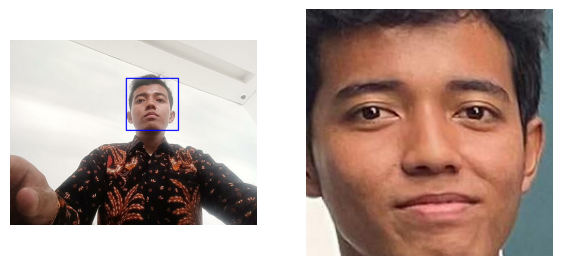

Hallo Irsan bupati sleman, selamat datang
Escape hit, closing...


In [59]:
# --- Tambahkan Webcam Input dengan Capturing Otomatis Tiap 10 Detik ---
# Inisialisasi webcam
cap = cv2.VideoCapture(0)

face_detected = False
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # Load face detector

img_counter = 0
capture_interval = 10  # Interval capture dalam detik
start_time = time.time()  # Waktu awal

while True:
    # Baca frame dari webcam
    ret, frame = cap.read()

    # Deteksi wajah di frame yang ditangkap
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Konversi frame ke grayscale
    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)  # Deteksi wajah

    # Jika wajah terdeteksi, tandai wajah di frame
    if len(faces) > 0:
        face_detected = True
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Gambar kotak di sekitar wajah

    # Tampilkan frame dari webcam dengan deteksi wajah
    cv2.imshow('Webcam', frame)

    # Jika wajah terdeteksi dan 10 detik berlalu, capture gambar
    current_time = time.time()
    if face_detected and (current_time - start_time >= capture_interval):
        img_counter += 1

        # Capture dan proses frame
        print(f"Face detected! Gambar ke-{img_counter} di-capture dan sedang diproses...")

        # Proses gambar target dari webcam
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
        target_embedding = DeepFace.represent(
            img_path=rgb_frame,  # Gunakan frame RGB langsung dari memori
            model_name=model_name,
            detector_backend=detector_backend,
            enforce_detection=False  # Allow processing even if no face detected
        )[0]["embedding"]

        # Konversi embedding ke array numpy dan expand dimensinya
        target_embedding = np.array(target_embedding, dtype="f")
        target_embedding = np.expand_dims(target_embedding, axis=0)

        # Cari embedding terdekat di FAISS
        k = 1  # Jumlah neighbor terdekat yang ingin dicari
        distances, neighbours = index.search(target_embedding, k)

        # Tampilkan hasil pencarian dari DataFrame
        for idx, neighbour in enumerate(neighbours[0]):
            if neighbour < len(df):
                neighbour_position = df.iloc[neighbour]['posisi']
                neighbour_name = df.iloc[neighbour]['name']
                neighbour_img_path = f"../Belajar-DeepFace/{representations[neighbour][0]}"

                # Ambil wajah neighbor dari gambar
                neighbour_img = DeepFace.extract_faces(
                    img_path=neighbour_img_path,
                    detector_backend=detector_backend
                )[0]["face"]

                # Visualisasikan gambar target dan neighbor
                print(f"{idx+1}th closest match: {neighbour_name}")

                fig = plt.figure(figsize=(7, 7))
                fig.add_subplot(1, 2, 1)
                plt.imshow(rgb_frame)  # Gunakan gambar RGB untuk ditampilkan
                plt.axis("off")
                fig.add_subplot(1, 2, 2)
                plt.imshow(neighbour_img)
                plt.axis("off")
                plt.show()

            else:
                print(f"Index {neighbour} out of range for DataFrame")

        print(f"Hallo {neighbour_name} {neighbour_position}, selamat datang")

        # Reset waktu awal setelah capture
        start_time = current_time
        face_detected = False  # Set ulang flag face_detected

    # Tekan ESC untuk keluar
    if cv2.waitKey(1) & 0xFF == 27:
        print("Escape hit, closing...")
        break

# Lepaskan resource webcam dan tutup window
cap.release()
cv2.destroyAllWindows()
